# Лінійна регресія: перенавчання і регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

В усіх комірках, де вказаний коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Решту комірок із кодом (без коментарів) треба просто виконати. Крім того, у завданні необхідно відповідати на запитання; відповіді потрібно вписувати після виділеного слова "__Відповідь:__".

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Ми будемо працювати з датасетом __"bikes_rent.csv"__, у якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати завдання регресії.

### Ознайомлення з даними

In [5]:
from google.colab import files
uploaded = files.upload()

Saving bikes_rent.csv to bikes_rent.csv


## Завдання 1

In [6]:
df = pd.read_csv("bikes_rent.csv")



In [7]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


In [8]:
print(df.shape)

(731, 13)


In [9]:
df.dtypes

,0
season,int64
yr,int64
mnth,int64
holiday,int64
weekday,int64
workingday,int64
weathersit,int64
temp,float64
atemp,float64
hum,float64


Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися в коректному зчитуванні даних:

Для кожного дня прокату відомі такі ознаки:
* _season_: 1 — весна, 2 — літо, 3 — осінь, 4 — зима
* _yr_: 0 — 2011, 1 — 2012
* _mnth_: від 1 до 12
* _holiday_: 0 — немає свята, 1 — є свято
* _weekday_: від 0 до 6
* _workingday_: 0 — неробочий день, 1 — робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях за годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, її ми будемо передбачати)

Отже, у нас є речові, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як з речовими. З номінальними ознаками теж можна працювати як з речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від решти.

Побудуйте графіки залежностей атрибутів від кількості поїздок. Іншими словами, вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибута від змінної **cnt**.

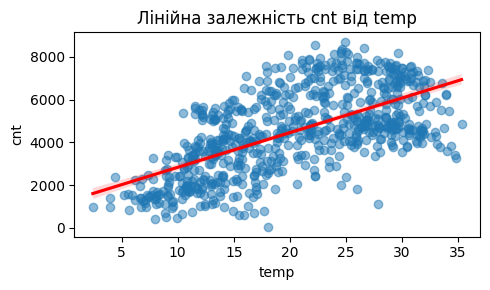

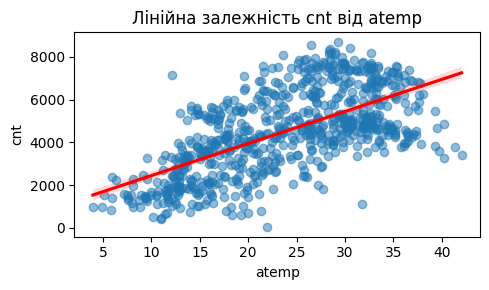

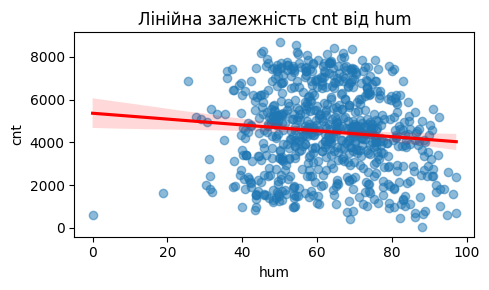

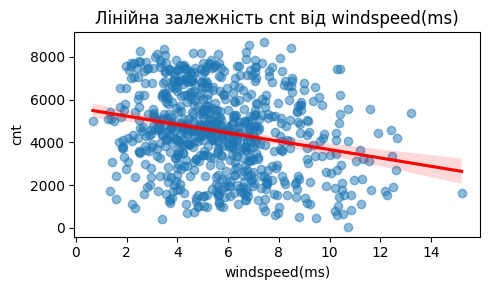

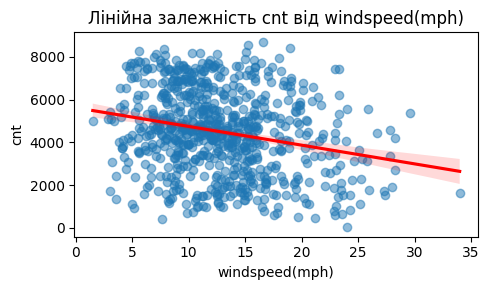

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
# графіки залежності речових ознак від cnt
num_features = ["temp", "atemp", "hum", "windspeed(ms)", "windspeed(mph)"]

for feature in num_features:
    plt.figure(figsize=(5,3))
    sns.regplot(x=feature, y="cnt", data=df,
                scatter_kws={"alpha": 0.5},
                line_kws={"color": "red"})
    plt.title(f"Лінійна залежність cnt від {feature}")
    plt.tight_layout()
    plt.show()

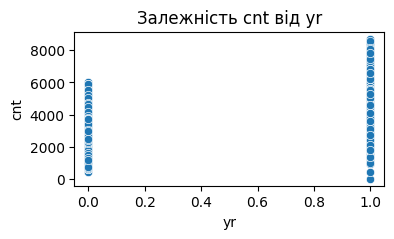

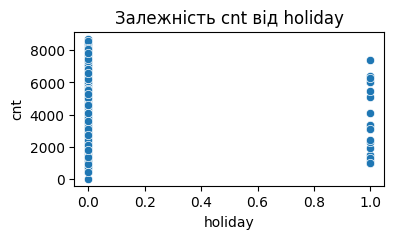

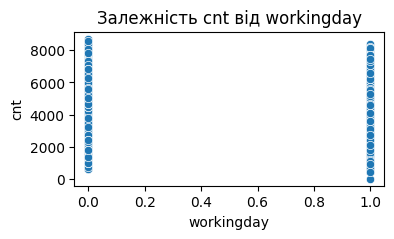

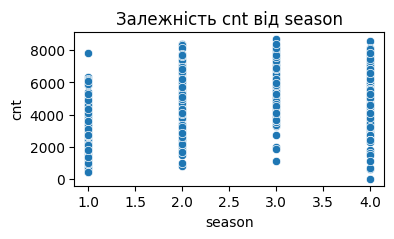

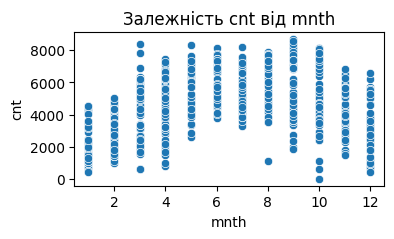

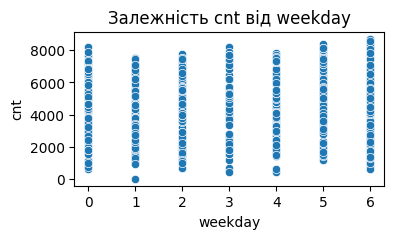

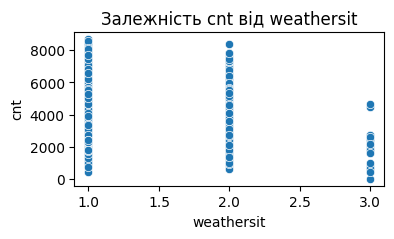

In [12]:
target = 'cnt'

# графіки залежності для бінарних та категоріальних ознак від cnt
features = ['yr', 'holiday', 'workingday', 'season', 'mnth', 'weekday', 'weathersit']

for col in features:
    plt.figure(figsize=(4,2))
    sns.scatterplot(x=col, y=target, data=df)
    plt.title(f'Залежність {target} від {col}')
    plt.xlabel(col)
    plt.ylabel(target)
    plt.show()

__Запитання:__
1. Яким є характер залежності кількості прокатів від місяця?
1. Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно.

1. **Відповдь**: З графіку видно що кількість прокатів явно залежить від пори року.Наблюдається зріст весною та літом з піком у вересні та спадом у зимку

2. **Відповідь**: Лінійна залежність простежується на графіках з ознаками temp, hum

## Завдання 2

Давайте більш строго оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr і corrwith.

Порахуйте кореляції всіх ознак, окрім останньої, з останньою за допомогою методу `corrwith`.

In [14]:
# корреляція між вхідними ознаками
df.drop(columns=['cnt']).corr()



,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms)
season,1.000000,-0.001844,0.831440,-0.010537,-0.003080,0.012485,0.019211,0.334315,0.342876,0.205445,-0.229046,-0.229046
yr,-0.001844,1.000000,-0.001792,0.007954,-0.005461,-0.002013,-0.048727,0.047604,0.046106,-0.110651,-0.011817,-0.011817
mnth,0.831440,-0.001792,1.000000,0.019191,0.009509,-0.005901,0.043528,0.220205,0.227459,0.222204,-0.207502,-0.207502
holiday,-0.010537,0.007954,0.019191,1.000000,-0.101960,-0.253023,-0.034627,-0.028556,-0.032507,-0.015937,0.006292,0.006292
weekday,-0.003080,-0.005461,0.009509,-0.101960,1.000000,0.035790,0.031087,-0.000170,-0.007537,-0.052232,0.014282,0.014282
workingday,0.012485,-0.002013,-0.005901,-0.253023,0.035790,1.000000,0.061200,0.052660,0.052182,0.024327,-0.018796,-0.018796
weathersit,0.019211,-0.048727,0.043528,-0.034627,0.031087,0.061200,1.000000,-0.120602,-0.121583,0.591045,0.039511,0.039511
temp,0.334315,0.047604,0.220205,-0.028556,-0.000170,0.052660,-0.120602,1.000000,0.991702,0.126963,-0.157944,-0.157944
atemp,0.342876,0.046106,0.227459,-0.032507,-0.007537,0.052182,-0.121583,0.991702,1.000000,0.139988,-0.183643,-0.183643
hum,0.205445,-0.110651,0.222204,-0.015937,-0.052232,0.024327,0.591045,0.126963,0.139988,1.000000,-0.248489,-0.248489


In [15]:
# корреляція цільової змінної cnt з вхідними ознаками
# 0,5 - 1 - помітна кореляція. Помітну кореляцію з цільовою змінною cnt мають ознаки temp, atemp, yr та season.
print(df.drop(columns=['cnt']).corrwith(df['cnt']).sort_values(ascending=False))

atemp             0.631066
temp              0.627494
yr                0.566710
season            0.406100
mnth              0.279977
weekday           0.067443
workingday        0.061156
holiday          -0.068348
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
weathersit       -0.297391
dtype: float64


У вибірці є ознаки, що корелюють із цільовою, а отже, завдання можна розв'язувати лінійними методами.

За графіками видно, що деякі ознаки схожі між собою. Тому давайте також порахуємо кореляції між речовими ознаками.

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt
за допомогою методу corr:

In [16]:
corr_colls = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']
matrix_corr = df[corr_colls].corr()

matrix_corr

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (тому що це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно позначається на навчанні лінійної моделі.

Насамкінець подивимося середні ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

## Завдання 4

Виведіть середні ознак.

In [17]:
df.mean()

,0
season,2.496580
yr,0.500684
mnth,6.519836
holiday,0.028728
weekday,2.997264
workingday,0.683995
weathersit,1.395349
temp,20.310776
atemp,23.717699
hum,62.789406


Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, у наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б одразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо її середнє і поділимо на стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, необхідно перемішати вибірку, це буде потрібно для крос-валідації.

In [18]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [19]:
df_shuffled = shuffle(df, random_state=42) # змішуємо дані
X = scale(df_shuffled[df_shuffled.columns[:-1]]) # стандартизуємо(мастшатабуємо) вхідні ознаки і повертаємо масштабовану матриця ознак
print(X)
y = df_shuffled["cnt"] # цільова змінна cnt


[[ 1.354375    0.99863295  1.58866019 ...  0.74372737 -0.21121111
  -0.21121111]
 [-1.34821315 -1.00136893 -1.31026791 ... -1.33538868  1.12681211
   1.12681211]
 [ 1.354375   -1.00136893  1.00887457 ... -0.29551449  0.50349108
   0.50349108]
 ...
 [ 1.354375   -1.00136893  0.71898176 ...  1.55169951 -0.5404777
  -0.5404777 ]
 [-1.34821315  0.99863295 -1.0203751  ... -1.06046036  0.41449871
   0.41449871]
 [-0.44735043 -1.00136893 -0.73048229 ...  1.34385394  0.77643372
   0.77643372]]


Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [20]:
from sklearn.linear_model import LinearRegression

## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються у змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


In [33]:
# модель
model = LinearRegression()

# навчання моделі
model.fit(X, y)

# ваги в змінній coef_
model.__dict__



{'fit_intercept': True,
 'copy_X': True,
 'n_jobs': None,
 'positive': False,
 'n_features_in_': 12,
 'coef_': array([ 5.70863796e+02,  1.02196538e+03, -1.41301745e+02, -8.67593446e+01,
         1.37225064e+02,  5.63918818e+01, -3.30226462e+02,  3.67483733e+02,
         5.85549386e+02, -1.45614306e+02,  1.24571384e+13, -1.24571384e+13]),
 'rank_': 12,
 'singular_': array([4.65355555e+01, 3.59555592e+01, 3.37054440e+01, 3.12352592e+01,
        2.96512266e+01, 2.67938846e+01, 2.65991928e+01, 2.32367889e+01,
        1.53445248e+01, 1.07778553e+01, 2.39832254e+00, 5.40974794e-11]),
 'intercept_': np.float64(4504.354528214392)}

In [23]:
feature_names = df_shuffled.columns[:-1] # назви ознак(колонок) з DataFrame

weights = model.coef_ # ваги
print(weights)

for feature, weight in zip(feature_names, weights):
    print(f"{feature}: {weight:.3f}")

season: 570.864
yr: 1021.965
mnth: -141.302
holiday: -86.759
weekday: 137.225
workingday: 56.392
weathersit: -330.226
temp: 367.484
atemp: 585.549
hum: -145.614
windspeed(mph): 12457138390688.885
windspeed(ms): -12457138390887.346


Ми бачимо, що ваги при лінійно-залежних ознаках за модулем значно більші, ніж при інших ознаках. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим менший визначник цієї матриці й тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколінеарності_.

З парою (temp, atemp) трохи менше корелюючих змінних такого не сталося, однак на практиці завжди варто уважно стежити за коефіцієнтами при схожих ознаках.

Для того щоб розв'язати проблему мультиколінеарності, потрібно скористатися регуляризатором. До оптимізуючого функціоналу додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а у другому — Ridge.

### Завдання 6
Давайте спробуємо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їхні ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилась.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги.

In [34]:
from sklearn.linear_model import Lasso

lasso = Lasso()
lasso.fit(X, y)

print("Lasso coefficients:")
for feature, weight in zip(feature_names, lasso.coef_):
    print(f"{feature}: {weight:.4f}")

Lasso coefficients:
season: 560.2416
yr: 1019.4635
mnth: -128.7306
holiday: -86.1528
weekday: 137.3479
workingday: 55.2124
weathersit: -332.3699
temp: 376.3632
atemp: 576.5308
hum: -144.1292
windspeed(mph): -197.1397
windspeed(ms): -0.0000


Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги.

In [37]:
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge.fit(X, y)
print("Ridge coefficients:")
for feature, weight in zip(feature_names, ridge.coef_):
    print(f"{feature}: {weight:.4f}")

Ridge coefficients:
season: 563.0646
yr: 1018.9484
mnth: -131.8733
holiday: -86.7461
weekday: 138.0051
workingday: 55.9031
weathersit: -332.3498
temp: 386.4579
atemp: 566.3470
hum: -145.0713
windspeed(mph): -99.2594
windspeed(ms): -99.2594


### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги при деяких ознаках. Давайте поспостерігаємо, як змінюються ваги зі збільшенням коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги у список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги у список`coefs_ridge`. Конвертуйте отримані списки в `np.array`.

In [65]:
alphas = np.arange(1, 500, 50) # alphas = [1, 51, 101, 151, 201, 251, 301, 351, 401, 451]

coefs_lasso = []
coefs_ridge = []
# alpha - параметр конструктора класса Lasso()
# current_alpha - змінна циклу

for current_alpha in alphas:
    # Lasso (L1)
    lasso1 = Lasso(alpha=current_alpha)
    lasso1.fit(X, y)
    coefs_lasso.append(lasso1.coef_)
     # Ridge (L2)
    ridge1 = Ridge(alpha=current_alpha)
    ridge1.fit(X, y)
    coefs_ridge.append(ridge1.coef_)

# Конвертація зі списку(list) у numpy array для аналіза і візуалізації
coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)
print("Lasso coefs:", type(coefs_lasso))
print("Ridge coefs:", type(coefs_ridge))
print("Lasso coefs:", coefs_lasso)
print("Ridge coefs:", coefs_ridge)
# При Lasso регулризації при збільшенні aplpha деякі ознаки вагів налижаються до 0 (частина вагів = 0 відбувається занулення деяких ознак)
# При Ridge регулризації ваги ознак поступово (монотонно) зменшуються але без обнулення

Lasso coefs: <class 'numpy.ndarray'>
Ridge coefs: <class 'numpy.ndarray'>
Lasso coefs: [[ 5.60241616e+02  1.01946349e+03 -1.28730627e+02 -8.61527813e+01
   1.37347894e+02  5.52123706e+01 -3.32369857e+02  3.76363236e+02
   5.76530794e+02 -1.44129155e+02 -1.97139689e+02 -2.80514042e-08]
 [ 4.10969632e+02  9.77019409e+02 -0.00000000e+00 -5.34489688e+01
   9.19434374e+01  1.75372118e+01 -3.18125568e+02  3.22829934e+02
   6.10031512e+02 -9.10689615e+01 -1.45066095e+02 -2.29892889e-08]
 [ 3.70077089e+02  9.35945490e+02  0.00000000e+00 -1.21619360e+01
   4.88886342e+01  0.00000000e+00 -3.08805664e+02  2.69417263e+02
   6.32502623e+02 -2.75042876e+01 -9.37749037e+01 -2.41657943e-08]
 [ 3.32835717e+02  8.91870058e+02  0.00000000e+00 -0.00000000e+00
   0.00000000e+00  0.00000000e+00 -2.79616688e+02  2.11052030e+02
   6.62920880e+02 -0.00000000e+00 -5.01551472e+01 -2.62789872e-08]
 [ 2.98134448e+02  8.45652857e+02  0.00000000e+00 -0.00000000e+00
   0.00000000e+00  0.00000000e+00 -2.35571345e+02  

Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:

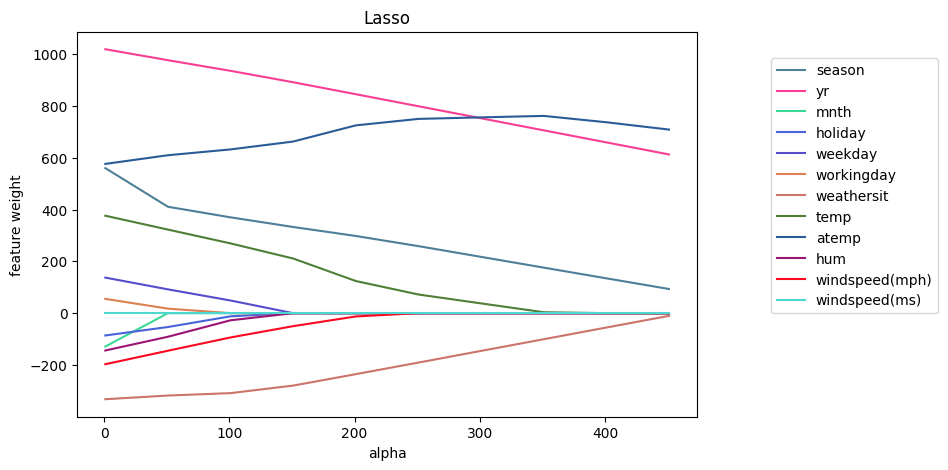

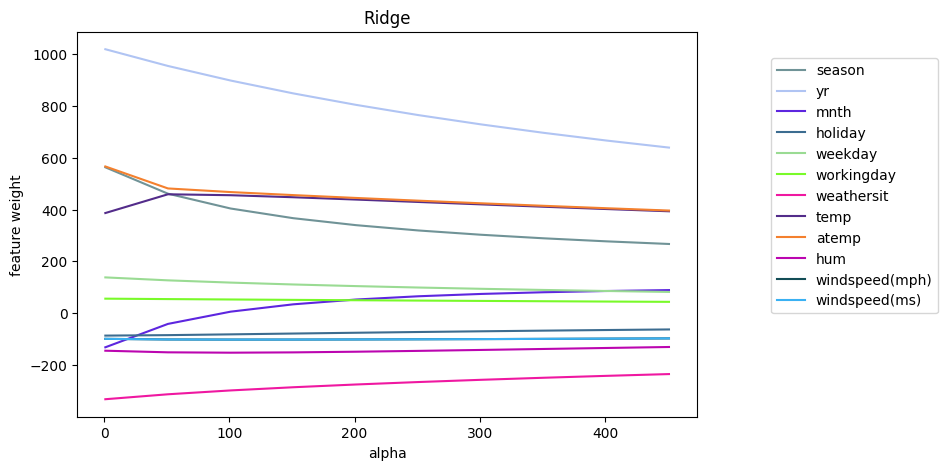

In [66]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при одному й тому самому alpha?
1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається.
1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` при будь-якому значенні `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт при ньому менший $10^{-3}$.
1. Який із регуляризаторів підійде для відбору неінформативних ознак?

1. **Відповідь**: Регуляризатор Lasso агресивніше зменшує ваги, ніж Ridge при однаковому значенні параметра alpha. Це видно з графіка: при Lasso регулризації при збільшенні aplpha деякі ознаки вагів стрімко налижаються до 0 (частина вагів = 0 відбувається занулення деяких ознак. Ridge-регуляризація зменшує ваги більш плавно і не зануляє коефіцієнти.

2. **Відповідь** При дуже великому значенні alpha коефіцієнти Lasso прямують до нуля і більшість із них стає рівною 0 (майже всі ваги стануть рівними 0) що позначиться на оцінці якості моделі( велике значення помилки і недонавчання )

3. **Відповідь** Так ,тому що має місце мультиколлінеарність і ці величини сильно корелюють між собою і тому при Lasso регуляризації ця ознака зануляється. А при Ridge регуляризації ваги можуть бути занадто малими і для корельованих ознак.

### Завдання 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику сам оптимізований функціонал методу найменших квадратів, тобто `Mean Square Error`.

По-друге, потрібно зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель буде робити передбачення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити декілька розбиттів вибірки, на кожному пробувати різні значення alpha, а потім усереднювати MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частин, і кожного разу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список із alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор буде містити змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків. Крім того, у змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що відповідають цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, у якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` в залежності від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [119]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = list(map(lambda e: e[0], data))
    y = list(map(lambda e: e[1], data))
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

In [162]:
from sklearn.linear_model import LassoCV
alphas = np.arange(1, 100, 5) # [ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81, 86, 91, 96]

# створюємо регресор LassoCV
regressor = LassoCV(alphas=alphas, cv=3)

# навчання на всіх ознаках
regressor.fit(X, y)

print("\nЗагальна матриця помилок для кожного alpha" ,regressor.mse_path_)

# середні значення помилок для кожного alpha
mse_mean = regressor.mse_path_.mean(axis=1)
print("\nCередні значення помилок для кожного alpha:", mse_mean)
print("\nОптимальне alpha:", regressor.alpha_)
print("\nМінімальне середнє значення помилки для вибраного alpha:", mse_mean.min()) # мінімальна середня помилка MSE





Загальна матриця помилок для кожного alpha [[830768.68693702 919721.93589263 805481.54522903]
 [822965.9041311  911867.54470864 804343.02766964]
 [815129.08593972 903855.55058088 803483.74706927]
 [807667.98224742 896148.95236924 802906.09265381]
 [800137.23263318 888747.72399201 801974.9311743 ]
 [793005.6616591  881651.8631318  800937.92121214]
 [786275.36724172 874861.36810104 799342.37031522]
 [779946.35004807 868376.23749144 798151.12777192]
 [774018.6100807  862196.47012638 797363.63293845]
 [768492.14733962 856322.06502308 796979.89551936]
 [763366.96182482 850359.8722302  796999.92588656]
 [758643.05353631 844566.95589129 797423.73295863]
 [754320.42247408 839080.96310802 798251.32439694]
 [750399.06863813 833901.906581   799482.70678255]
 [746878.99046623 829029.79332371 801117.80350671]
 [742255.05212855 824464.62917087 801674.30830821]
 [738465.37393446 819052.82694159 802734.32163988]
 [735622.01588326 810953.6137859  804327.50220445]
 [733725.76040522 804415.01327126 8064

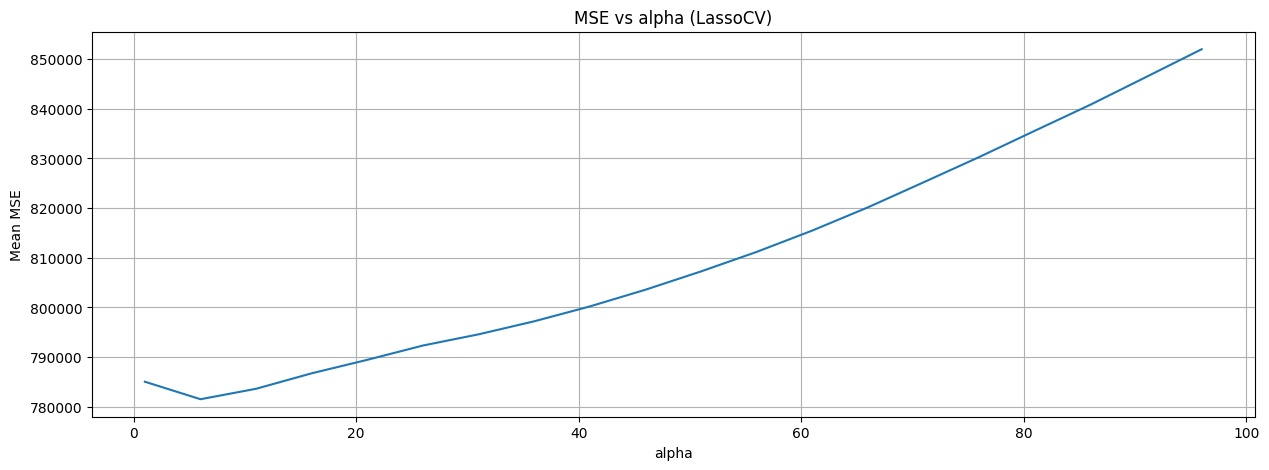


Оптимальне alpha: 6

Найкращі Ваги для вибраного alpha:
season      :   532.0190
yr          :  1015.0602
mnth        :  -100.0395
holiday     :   -83.2940
weekday     :   132.5045
workingday  :    51.5571
weathersit  :  -330.5599
temp        :   370.6799
atemp       :   581.3969
hum         :  -140.0074
windspeed(mph):  -191.7714
windspeed(ms):    -0.0000


In [156]:
# print(regressor.alphas_)
data_for_plot = list(zip(regressor.alphas_, mse_mean))
create_plot(data_for_plot,
            title="MSE vs alpha (LassoCV)",
            xlabel="alpha",
            ylabel="Mean MSE")

print("\nНайкращі Ваги для вибраного alpha:")
for feature, coef in zip(df.columns[:-1], regressor.coef_):
    print(f"{feature:12}: {coef:10.4f}")

Отже, ми вибрали певний параметр регуляризації. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто за стовпцями).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


In [163]:
# шукаємо найкраще alpha по кожному стовпцю (fold) що відповідають мінімальному MSE
best_alpha_per_fold = regressor.alphas_[regressor.mse_path_.argmin(axis=0)]
print(best_alpha_per_fold)
feature_names = df.columns[:-1]

# навчання для кожного найкращого alpha по кожному стовпцю
for i, alpha in enumerate(best_alpha_per_fold, 1):
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)

    print(f"\nFold {i}: alpha = {alpha}")
    for feature, coef in zip(feature_names, lasso.coef_):
        print(f"{feature:15s}: {coef: .4f}")


[ 6  1 51]

Fold 1: alpha = 6
season         :  532.0190
yr             :  1015.0602
mnth           : -100.0395
holiday        : -83.2940
weekday        :  132.5045
workingday     :  51.5571
weathersit     : -330.5599
temp           :  370.6799
atemp          :  581.3969
hum            : -140.0074
windspeed(mph) : -191.7714
windspeed(ms)  : -0.0000

Fold 2: alpha = 1
season         :  560.2416
yr             :  1019.4635
mnth           : -128.7306
holiday        : -86.1528
weekday        :  137.3479
workingday     :  55.2124
weathersit     : -332.3699
temp           :  376.3632
atemp          :  576.5308
hum            : -144.1292
windspeed(mph) : -197.1397
windspeed(ms)  : -0.0000

Fold 3: alpha = 51
season         :  410.9696
yr             :  977.0194
mnth           : -0.0000
holiday        : -53.4490
weekday        :  91.9434
workingday     :  17.5372
weathersit     : -318.1256
temp           :  322.8299
atemp          :  610.0315
hum            : -91.0690
windspeed(mph) : -145.066

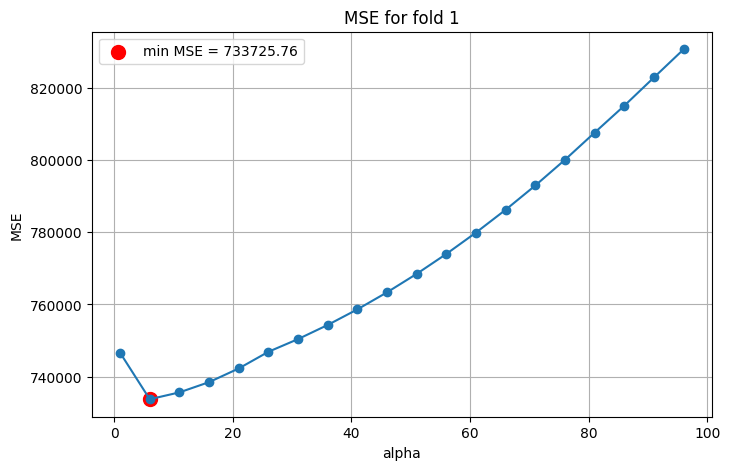

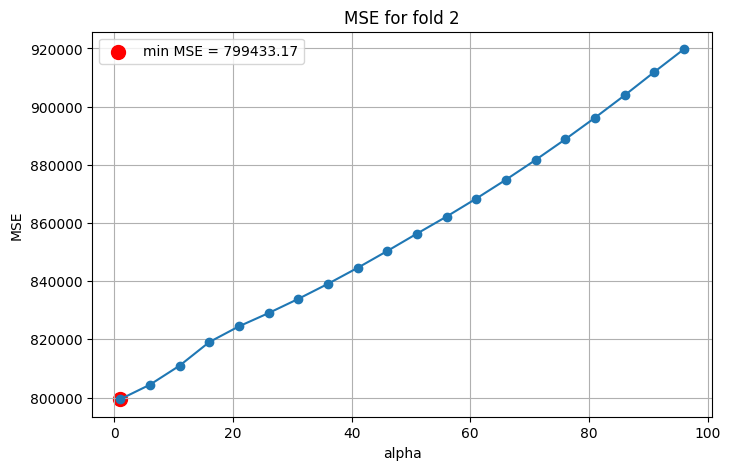

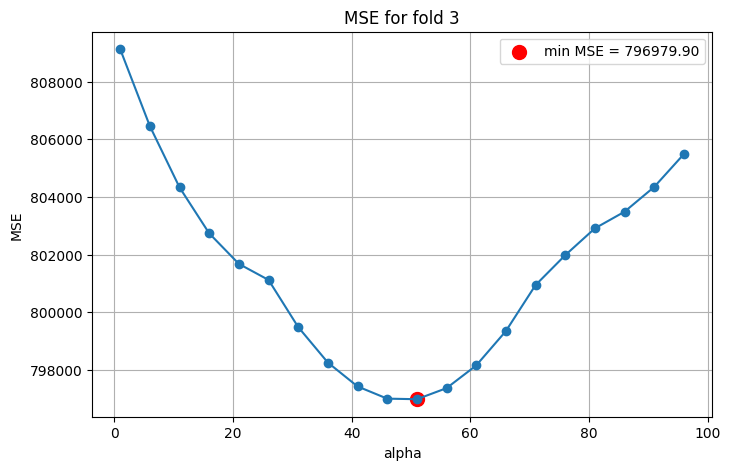

In [151]:
k = regressor.mse_path_.shape[1]  # кількість блоків (fold)

for i in range(k):
    plt.figure(figsize=(8, 5))
    plt.plot(regressor.alphas_, regressor.mse_path_[:, i], marker='o')
    plt.title(f"MSE for fold {i+1}")
    plt.xlabel("alpha")
    plt.ylabel("MSE")
    # мінімальне MSE для кожного fold
    min_idx = regressor.mse_path_[:, i].argmin()
    plt.scatter(regressor.alphas_[min_idx], regressor.mse_path_[min_idx, i], color='red', s=100, label=f"min MSE = {regressor.mse_path_[min_idx, i]:.2f}")
    plt.legend()
    plt.grid()
    plt.show()

На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо дещо "середнє", що даватиме прийнятне значення метрики на різних розбиттях вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, давайте проінтерпретуємо результат. Дайте відповіді на наступні запитання.

#### Запитання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей `cnt` від цих ознак, які ми зображали у блоці "Ознайомлення з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

**Відповідь:** season = 532.0190 ,yr = 1015.0602 , weekday = 132.5045 temp = 370.6799 , atemp=581.3969.

За побудованими графіками чітко простежується для деяких ознак зростаюча лінійна залежність(temp,atemp) а для частини інших вона не є строго лінійною.

#### Запитання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. Чи видно лінійну залежність, що зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

**Відповідь:** hum = -140 , windspeed = -191 , weathershit = -330

Так простежується лінійна залежність що зменшується для деяких речових ознак (hum,windspeed)

windspeed - чим більше швидкість вітру тим менше прокатів.

hum - чим більше вологість тим менше прокат велосипедів

weathershit - не є лінійною , але видно що за сприятливих погодних умов кількість оренди велосипедів зростає


#### Запитання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (< 1e-3). Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? Чи правда, що вони ніяк не впливають на попит на велосипеди?

**Відповідь:** winspeed(ms). Модель виключила її щоб запобігти мультиколлінеарності між windspeed(ms) та windspeed(mph) які відрізняєються одиницями виміру та не захаращувати модель.

### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, за можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів. (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться декілька разів навчати модель. Такий процес займає багато часу, особливо якщо треба навчатися на великих обсягах даних.